# Simple Games

In [10]:
from utils import *
import utils

In [11]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [12]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu', input_dim=S)
        self.W2 = tf.keras.layers.Dense(A, 'softmax', input_dim=50)
    
    def __call__(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return x
    
create_nn = lambda S,A: Model(S,A)

In [13]:
def discount_rewards(R, y=0.99, normalize=True):
    ''' [n] -> [n] w/ discounted rewards '''
    G = np.zeros_like(R)
    for t in range(len(R)-1,-1,-1):
        G[t] = R[t] + y*G[t+1] if t+1 < len(R) else R[t]
    return (G - G.mean() ) / G.std() if normalize else G

In [14]:
class Agent():
    def __init__(self, num_states, num_actions, gamma=0.99, lr=1e-2):
        self.S, self.A = num_states, num_actions
        self.nn = create_nn(self.S, self.A)
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
    
    def first_step(self, s, sdict): # [1,S], dict to store metrics
        pi = self.nn(s) # [1,A]
        a = np.argmax(pi, axis=-1) # [1,A]
        self.E = [] # init episode dataset/buffer
        self.s, self.a = s, utils.one_hot(a, C=self.A) # save state + onehot action
        return a
        
    def step(self, r, s, sdict): # [], [1,S], dict to store metrics
        self.E.append([self.s, self.a, r, s]) # s, a, r, s'
        pi = self.nn(s) # [1,A]
        a = tf.random.categorical(tf.math.log(pi), num_samples=1) # [1,1]
        a = int(a.numpy()[0,0]) # []
        a_enc = utils.one_hot(a, C=self.A) # [1,A]
        self.s, self.a, self.pi = s, a_enc, pi # save previous state, action, action probs
        return a
    
    def last_step(self, r, sdict): # [], dict to store metrics
        self.E.append([self.s, self.a, r, None]) # s, a, r, s'
        # need squeeze, because self.s/a is [1,S/A], so S=[e,1,S/A] -> [e,S/A]
        S = np.squeeze(np_map(lambda x: x[0], self.E)) # [e,S], where e - number steps in episode
        if S.ndim == 1: S = np.expand_dims(S, axis=0) # for cases if example size is 1 and squeezed
        A = np.squeeze(np_map(lambda x: x[1], self.E)) # [e,A]
        # prerprocess reward
        R = np_map(lambda x: x[2], self.E) # [e]
        R = discount_rewards(R, self.gamma)[:,np.newaxis] # [e,1]
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            A_hat = self.nn(S) # [e,A]
            A_hat = tf.clip_by_value(A_hat, 1e-6, 1-1e-6) # clip tf.log(0)
            each_loss = -tf.reduce_sum(R * A * tf.math.log(A_hat), axis=-1) # [e]
            loss = tf.reduce_mean(each_loss) # avg of all examples
        # calc + update gradients
        nn_vars = self.nn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(tuple(zip(grads, nn_vars)))

In [16]:
agent_fn = lambda S,A,env_fn=None: Agent(num_states=S, num_actions=A, lr=1e-2, gamma=0.99)

In [9]:
test_agent_on_simple_games(agent_fn, 'PG', game_dict={'CartPole-v1':500})

True

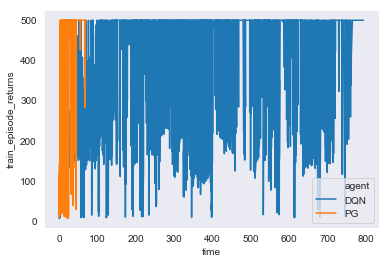

In [18]:
df = load_my_benchmark('CartPole-v1')
# df
plot_df(df, x='time')

In [17]:
exp = Experiment(env, agent_fn(S,A))
df = exp.run(500, 1, name='')
# plot_df(df)
# exp.show_play(500)

KeyboardInterrupt: 

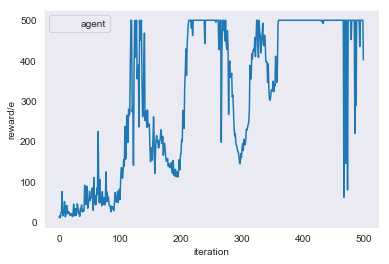

In [47]:
plot_df(df, y='reward/e')

In [ ]:
test_agent_on_simple_games(agent_fn, 'PG')

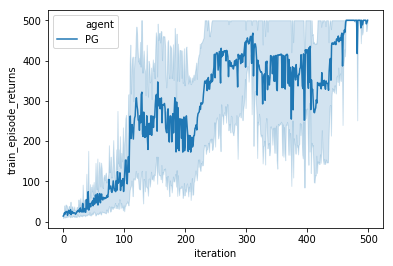

In [13]:
df = load_my_benchmark('CartPole-v1')
plot_df(df)

# Atari (pixels)

In [23]:
from utils import *
import utils

In [24]:
GAME = 'VideoPinball'
env = create_atari_env(GAME)
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(84, 84, 1)
Discrete(9)
(-inf, inf)


In [25]:
S = [84,84,4] # state shape
A = 6 # num actions

In [ ]:
create_nn = lambda: tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=S),
    tf.keras.layers.Conv2D(32, kernel_size=[8,8], strides=[4,4]),
    tf.keras.layers.Conv2D(64, kernel_size=[4,4], strides=[2,2]),
    tf.keras.layers.Conv2D(64, kernel_size=[3,3], strides=[1,1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(A, 'softmax'),
])

create_nn().summary()

In [27]:
agent = Agent(create_nn(), num_actions=A, lr=1e-5)
exp = Experiment(env, agent)

In [ ]:
df = exp.run(iters=20, name='PG')